In [1]:
# Modelos usados
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Processamento de dados
import pandas as pd
import numpy as np

# Usado no modelo
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

# Graficos que ilustram o modelo
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dados = pd.read_csv('dados_filtrados.csv',sep=';').dropna()
dados.head(5)

,vacina_descricao_dose,paciente_idade,paciente_racaCor_valor,paciente_endereco_uf,vacina_categoria_nome,paciente_enumSexoBiologico
0,1ª Dose,38.0,AMARELA,SP,Faixa Etária,M
1,3ª Dose,5.0,BRANCA,RS,Faixa Etária,M
2,1ª Dose,48.0,SEM INFORMACAO,SP,Faixa Etária,M
3,1ª Dose,77.0,SEM INFORMACAO,MG,Faixa Etária,F
4,Reforço,63.0,SEM INFORMACAO,SP,Faixa Etária,M


In [3]:
dados = dados.astype({
    'vacina_descricao_dose' : 'category',
    'paciente_idade' : 'int8',
    'paciente_racaCor_valor' : 'category',
    'paciente_endereco_uf' : 'category',
    'vacina_categoria_nome' : 'category',
    'paciente_enumSexoBiologico' : 'category'
})

# `Sobre o projeto`:

Com o intuito de entender a aderência vacinal pelo território brasileiro, esse projeto desenvolve maneiras de prever a quantitade de vacinas tomadas por um brasileiro a depender do seu perfil e dados pessoais.

Para atingir tal objetivo, foram desenvolvidos três modelos distintos, cujas precisões e resultados foram comparados a fim de decidir qual o melhor deles para a tarefa proposta. Esses são o `Modelo Logístico`, `Decision Tree` e o `Random Forest`.

Durante o projeto, diferentes iterações foram desenvolvidas a fim de melhorar a precisão das previsões obtidas.

### Pré-processamento dos dados

**Padronização dos dados da coluna `paciente_idade`**

Esse passo é necessário para aumentar a acurácia do modelo pois distribui os dados em um range de média 0 e desvio padrão e 1.

In [4]:
scaler = StandardScaler()
scaler_fit = scaler.fit_transform(dados['paciente_idade'].to_frame())

**Converter variáveis categóricas em variáveis booleanas**

Assim, é possível utilizá-las no modelo de Regressão Logística.
A função `get_dummies()` retorna um `DataFrame` onde, para cada categoria, há uma coluna de valores booleanos que correspondem a existência ou não daquela categoria nas células abaixo.

In [5]:
uf = pd.get_dummies(dados["paciente_endereco_uf"],drop_first=True).reset_index(drop=True)
sexobio = pd.get_dummies(dados["paciente_enumSexoBiologico"],drop_first=True).reset_index(drop=True)
cor = pd.get_dummies(dados["paciente_racaCor_valor"],drop_first=True).reset_index(drop=True)
categoria = pd.get_dummies(dados["vacina_categoria_nome"],drop_first=True).reset_index(drop=True)

FeaturesProcessadas = pd.concat([
    pd.Series(scaler_fit.flatten(), name="Idade do Paciente"),
    uf,
    sexobio,
    cor,
    categoria
    ], axis=1)

FeaturesProcessadas.columns = FeaturesProcessadas.columns.astype(str)


TargetProcessado = dados["vacina_descricao_dose"].reset_index(drop=True)
display(FeaturesProcessadas)

,Idade do Paciente,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,População Privada de Liberdade,Povos Indígenas,Povos e Comunidades Tradicionais,Puérperas,Trabalhadores Industriais,Trabalhadores Portuários,Trabalhadores da Educação,Trabalhadores de Limpeza Urbana,Trabalhadores de Saúde,Trabalhadores de Transporte
0,-0.267260,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-1.912179,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.231201,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.676736,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.978891,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994902,0.729661,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
994903,0.530277,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
994904,-1.114643,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
994905,1.128430,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Separando o banco de dados entre `train` e `test`**

In [6]:
randomState = randint(0,100000)
x_train,x_test = train_test_split(FeaturesProcessadas, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)
y_train,y_test = train_test_split(TargetProcessado, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

### Treinamento dos modelos:

`Modelo Logístico`

In [7]:
modelL = LogisticRegression(class_weight='balanced')
modelL.fit(x_train,y_train)

c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

`Random Forest`

In [8]:
modelRF = RandomForestClassifier(class_weight="balanced")
modelRF.fit(x_test, y_test)

RandomForestClassifier(class_weight='balanced')

`Decision Tree`

In [9]:
modelDT = DecisionTreeClassifier(splitter='random', class_weight="balanced")
modelDT.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', splitter='random')

### Resultados

In [10]:
testsResultL = modelL.predict(x_test)  # Modelo Logístico
testsResultRF = modelRF.predict(x_test)  # Random Forest
testsResultDT = modelDT.predict(x_test)  # Decision Tree

`Logistic Regression`

In [11]:
print(classification_report(y_test,testsResultL))

c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

            1ª Dose       0.35      0.01      0.02     91114
    1ª Dose Dobrada       0.00      0.00      0.00         0
1ª Dose Revacinação       0.00      0.07      0.00       184
         1º Reforço       0.02      0.47      0.04      1288
            2ª Dose       0.32      0.00      0.01     84094
2ª Dose Revacinação       0.00      0.22      0.00       165
         2º Reforço       0.14      0.25      0.18     23713
            3ª Dose       0.04      0.21      0.06      1983
3ª Dose Revacinação       0.00      0.25      0.00        88
         3º Reforço       0.01      0.35      0.02       586
            4ª Dose       0.05      0.56      0.08       476
4ª Dose Revacinação       0.00      0.22      0.00       100
         4º Reforço       0.01      0.97      0.02        75
            5ª Dose       0.00      0.72      0.00        18
5ª Dose Revacinação       0.00      0.10      0.00        10
               Dose    

c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


`Random Forest`

In [12]:
print(classification_report(y_test,testsResultRF))

                     precision    recall  f1-score   support

            1ª Dose       0.62      0.29      0.40     91114
1ª Dose Revacinação       0.05      0.93      0.10       184
         1º Reforço       0.10      0.86      0.18      1288
            2ª Dose       0.57      0.29      0.38     84094
2ª Dose Revacinação       0.05      0.96      0.09       165
         2º Reforço       0.25      0.47      0.32     23713
            3ª Dose       0.16      0.78      0.27      1983
3ª Dose Revacinação       0.04      0.98      0.08        88
         3º Reforço       0.08      0.92      0.15       586
            4ª Dose       0.16      0.95      0.28       476
4ª Dose Revacinação       0.05      0.99      0.10       100
         4º Reforço       0.08      1.00      0.16        75
            5ª Dose       0.08      1.00      0.15        18
5ª Dose Revacinação       0.08      1.00      0.15        10
               Dose       0.07      0.84      0.13      2501
     Dose Adicional    

`Decision Tree`

In [13]:
print(classification_report(y_test,testsResultDT))

c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                     precision    recall  f1-score   support

            1ª Dose       0.38      0.13      0.19     91114
    1ª Dose Dobrada       0.00      0.00      0.00         0
1ª Dose Revacinação       0.00      0.05      0.00       184
         1º Reforço       0.04      0.47      0.07      1288
            2ª Dose       0.32      0.11      0.17     84094
2ª Dose Revacinação       0.00      0.05      0.00       165
         2º Reforço       0.13      0.23      0.16     23713
            3ª Dose       0.07      0.37      0.11      1983
3ª Dose Revacinação       0.00      0.01      0.00        88
         3º Reforço       0.01      0.20      0.02       586
            4ª Dose       0.04      0.42      0.08       476
4ª Dose Revacinação       0.00      0.06      0.00       100
         4º Reforço       0.02      0.35      0.03        75
            5ª Dose       0.00      0.06      0.01        18
5ª Dose Revacinação       0.00      0.00      0.00        10
               Dose    

c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


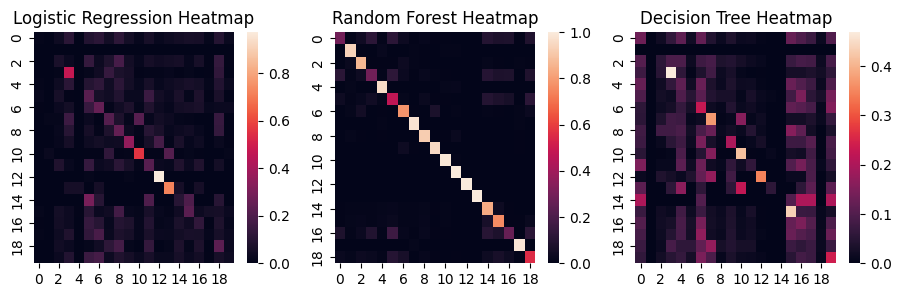

In [14]:
plt.figure(figsize=(11,3))

plt.subplot(131)
sns.heatmap(confusion_matrix(y_test,testsResultL,normalize='true'))
plt.title("Logistic Regression Heatmap")

plt.subplot(132)
sns.heatmap(confusion_matrix(y_test,testsResultRF,normalize='true'))
plt.title("Random Forest Heatmap")

plt.subplot(133)
sns.heatmap(confusion_matrix(y_test,testsResultDT,normalize='true'))
plt.title("Decision Tree Heatmap")
plt.show()

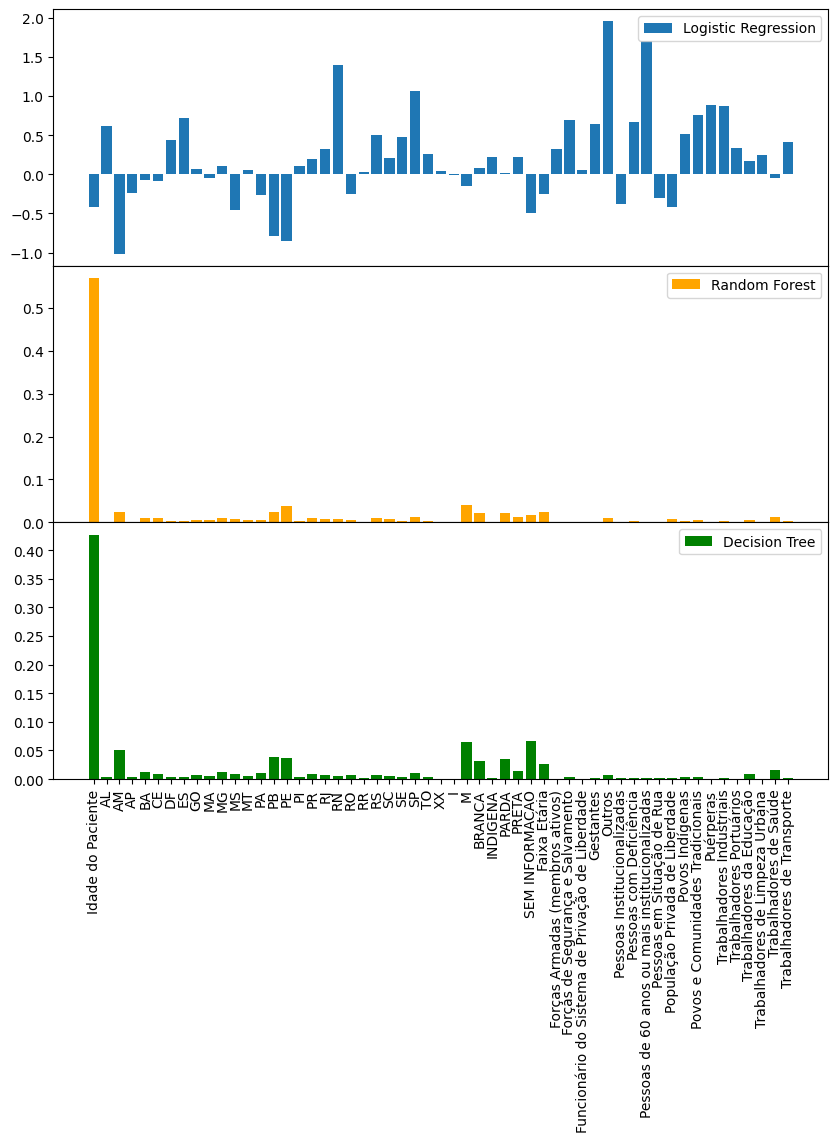

In [48]:
plt.figure(figsize=(10,10))
importance = pd.DataFrame({
    "Logistic Regression" : modelL.coef_[0],
    "Random Forest" : modelRF.feature_importances_,
    "Decision Tree" : modelDT.feature_importances_
},index = x_test.columns)

plt.subplots_adjust(hspace=.0)

plt.subplot(311)
plt.bar(x_test.columns,modelL.coef_[0], label="Logistic Regression")
plt.legend()
plt.xticks([])

plt.subplot(312)
plt.bar(x_test.columns,modelRF.feature_importances_, label="Random Forest", color='orange')
plt.legend()
plt.xticks([])

plt.subplot(313)
plt.bar(x_test.columns,modelDT.feature_importances_, label="Decision Tree",color='green')
plt.legend()
plt.xticks(rotation=90)


plt.show()

In [ ]:
y_previsao = rf.predict(X_teste)
accuracy = accuracy_score(y_teste,y_previsao)

print('Accuracy:', accuracy)

print(classification_report(y_teste,y_previsao))

Accuracy: 0.47048141707960184


c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            1ª Dose       0.48      0.58      0.52     91584
    1ª Dose Dobrada       0.00      0.00      0.00         1
1ª Dose Revacinação       0.73      0.13      0.21       175
         1º Reforço       0.53      0.40      0.46      1355
            2ª Dose       0.48      0.47      0.47     84194
2ª Dose Revacinação       0.65      0.10      0.18       148
         2º Reforço       0.55      0.17      0.25     23768
            3ª Dose       0.54      0.25      0.35      1982
3ª Dose Revacinação       0.67      0.06      0.11        67
         3º Reforço       0.69      0.18      0.29       540
            4ª Dose       0.61      0.25      0.36       506
4ª Dose Revacinação       0.65      0.11      0.19       101
         4º Reforço       1.00      0.08      0.15        63
            5ª Dose       0.54      0.44      0.48        16
5ª Dose Revacinação       1.00      0.36      0.53        11
               Dose    

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


___

## 1ª ITERACAO
### SIMPLIFICANDO BANCO DE DADOS
`ITERANDO`: Vamos usar os mesmos métodos em ambos os modelos, pois simplificará a análise de dados e fará com que nossas estimativas sejam  compativeis e aptas a comparacao entre diferentes modelos . 


-A primeira iteração foi feita por meio do Feature Selection

Dado que a coluna `target` possui muitas categorias distintas (19 opções de descrição para a dose da vacina), o modelo tem dificuldade em prever o caso em que o paciente tomou a `3ª dose`.
Para melhorar a quantidade de dados disponíveis, essa coluna irá ser simplificada em rótulos.

In [ ]:
display(pd.Series(dados['vacina_descricao_dose'].unique()).to_frame())

,0
0,1ª Dose
1,3ª Dose
2,Reforço
3,2ª Dose
4,Única
5,2º Reforço
6,Dose
7,Revacinação
8,Dose Adicional
9,1º Reforço


A simplificação será feita da seguinte maneira:

1ª Dose : `1ª Dose Revacinação`, `1ª Dose Dobrada`, `1º Reforço`, `Única`, `Reforço`, `Dose` e `Revacinação`\
2ª Dose: `2º Reforço`, `2ª Dose Revacinação`, `Dose Adicional`\
3ª Dose: `3º Reforço` e `3ª Dose Revacinação`\
4ª Dose: `4º Reforço` e `4ª Dose Revacinação`\
5ª Dose: `5ª Dose Revacinação`



In [ ]:
TargetProcessado2 = dados["vacina_descricao_dose"].astype('string')

TargetProcessado2.loc[TargetProcessado2.isin(["1ª Dose Revacinação","1ª Dose Dobrada","1º Reforço","Única","Reforço","Dose","Revacinação"])] = "1ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["2º Reforço","2ª Dose Revacinação","Dose Adicional"])] = "2ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["3º Reforço","3ª Dose Revacinação"])] = "3ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["4º Reforço","4ª Dose Revacinação"])] = "4ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["5ª Dose Revacinação"])] = "5ª Dose"

TargetProcessado2 = TargetProcessado2.astype('category')

In [ ]:
(TargetProcessado2.value_counts(normalize=True)*100).round(2)

vacina_descricao_dose
1ª Dose    61.81
2ª Dose    37.10
3ª Dose     0.87
4ª Dose     0.22
5ª Dose     0.01
Name: proportion, dtype: float64

**Separando a nova coluna `Target` entre `train` e `test`**

In [ ]:
y_train,y_test = train_test_split(TargetProcessado2, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

**Aplicando o novo `Target` ao modelo**

In [ ]:
model = LogisticRegression(solver="sag",class_weight='balanced')
model.fit(x_train,y_train)

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', solver='sag')

**Resultados do modelo**

In [ ]:
testsResult = model.predict(x_test)
print(classification_report(y_test,testsResult))

              precision    recall  f1-score   support

     1ª Dose       0.62      0.76      0.68    185049
     2ª Dose       0.37      0.16      0.22    110084
     3ª Dose       0.02      0.16      0.04      2636
     4ª Dose       0.02      0.32      0.04       674
     5ª Dose       0.00      0.10      0.01        30

    accuracy                           0.53    298473
   macro avg       0.21      0.30      0.20    298473
weighted avg       0.52      0.53      0.50    298473



-Analisando o modelo `Random Forest`:

In [ ]:
y_treino,y_teste = train_test_split(TargetProcessado2, test_size=.3 , train_size=.7)

**Aplicando o novo `Target` ao modelo**

In [ ]:
# Treinando o modelo.
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_teste, y_teste)

RandomForestClassifier(class_weight='balanced')

**Resultados do modelo**

In [ ]:
testsResult = rf.predict(X_teste)
print(classification_report(y_teste,testsResult))



              precision    recall  f1-score   support

     1ª Dose       0.76      0.53      0.62    184407
     2ª Dose       0.54      0.51      0.52    110760
     3ª Dose       0.05      0.86      0.10      2634
     4ª Dose       0.03      0.99      0.06       638
     5ª Dose       0.03      1.00      0.06        34

    accuracy                           0.53    298473
   macro avg       0.28      0.78      0.27    298473
weighted avg       0.67      0.53      0.58    298473



`COMPARANDO OS RESULTADOS POR MEIO DO GRAFICO DE CALOR`:


`LOGISTICO`:

In [ ]:
sns.heatmap(confusion_matrix(y_test,testsResult,normalize='true'),annot=True)

NameError: name 'y_test' is not defined

`RANDOM FOREST`:

In [ ]:
sns.heatmap(confusion_matrix(y_teste,testsResult,normalize='true'),annot=True)

NameError: name 'y_teste' is not defined

___
### `SEGUNDA ITERACAO`:

Agora, a coluna foi definida entre os valores `True` e `False` para se o paciente tomou a partir da 2ª dose da vacina.
A partir dessa nova analise feita, foi possivel chegar em resultados mais precisos.


___
### `LOGISTICO:`

In [ ]:
TargetProcessado3 = TargetProcessado2.isin(["2ª Dose","3ª Dose","4ª Dose","5ª Dose"])
print(TargetProcessado3.value_counts(normalize=True))

vacina_descricao_dose
False    0.618053
True     0.381947
Name: proportion, dtype: float64


In [ ]:
y_train,y_test = train_test_split(TargetProcessado3, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

In [ ]:
model = LogisticRegression()
model.fit(x_train,y_train)

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
testsResult = model.predict(x_test)
print(classification_report(y_test,testsResult))

              precision    recall  f1-score   support

       False       0.62      1.00      0.77    185049
        True       0.56      0.00      0.00    113424

    accuracy                           0.62    298473
   macro avg       0.59      0.50      0.38    298473
weighted avg       0.60      0.62      0.47    298473



In [ ]:
TargetProcessado3 = TargetProcessado2.isin(["2ª Dose","3ª Dose","4ª Dose","5ª Dose"])
print(TargetProcessado3.value_counts(normalize=True))

vacina_descricao_dose
False    0.618053
True     0.381947
Name: proportion, dtype: float64


In [ ]:
y_treino,y_teste = train_test_split(TargetProcessado3, test_size=.3 , train_size=.7)

In [ ]:
# Treinando o modelo.
rf = RandomForestClassifier()
rf.fit(X_teste, y_teste)

RandomForestClassifier()

In [ ]:
testsResult = rf.predict(X_teste)
print(classification_report(y_teste,testsResult))

              precision    recall  f1-score   support

       False       0.68      0.91      0.78    184514
        True       0.68      0.30      0.41    113959

    accuracy                           0.68    298473
   macro avg       0.68      0.60      0.60    298473
weighted avg       0.68      0.68      0.64    298473



___
# COMPARANDO OS MODELOS:

 `LOGISTICO`:

<Axes: >

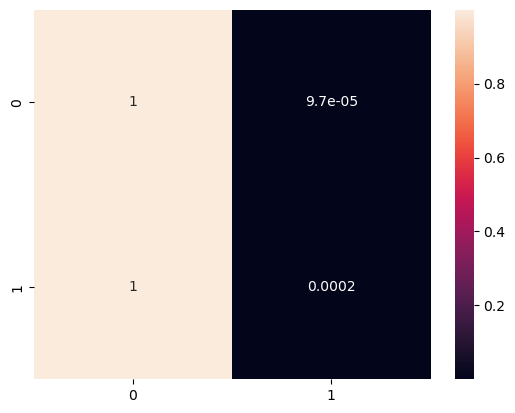

In [ ]:
sns.heatmap(confusion_matrix(y_test,testsResult,normalize='true'),annot=True)

-`RANDOM FOREST`

In [ ]:
sns.heatmap(confusion_matrix(y_teste,testsResult,normalize='true'),annot=True)

NameError: name 'y_teste' is not defined

### `CONCLUSAO`: